In [1]:
#IMPORT Libraries
import pandas as pd
import numpy as np
import math
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from IPython.display import display

In [2]:
# create a dataframe for the pipe data. This is done bases on my local files, but need to aligned to the final result of the Feature Engineering and Data Cleaning
#point to the folder where the data is stored for Diana
os.chdir(r"C:\Users\dianaf\OneDrive\IE\Datathon") 

df_submission= pd.read_csv("sample_submission.csv") #909733 rows - test data set
df_submission = df_submission.drop(['Incidence'], axis=1)

In [3]:
df_network= pd.read_csv("network.csv") # 1446539 rows - total data set

df_inspection= pd.read_csv("inspections.csv") #6345344 rows - inspection data set

df = pd.merge(df_network, df_submission, on="PipeId", how='right')

df_ins = pd.merge(df_inspection, df_submission, on="PipeId", how='right')

In [4]:
#keep only one PipeId per row where InspectionDate is the most recent
df_ins_clean= df_ins.sort_values('InspectionDate', ascending=False).drop_duplicates('PipeId')
df_ins_clean.shape

(909733, 7)

In [5]:
#Merging both the summarized inspection data and the network data
df_cost = pd.merge(df_ins_clean, df, on="PipeId", how='right')
df_cost.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,446859944,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0,Valencia,Alginet,2012,PE,Gas natural,110.0,44.286,0.15,0,0,False
1,428124500,ZRV-00003028,2019.0,2019-01-10,24.0,4.0,0.0,Valencia,Alginet,2012,PE,Gas natural,160.0,110.715,0.15,2,0,False
2,438428871,ZRV-00003028,2019.0,2018-12-27,23.0,4.0,0.0,Valencia,Alginet,2012,PE,Gas natural,110.0,13.575,0.15,0,0,False
3,429034569,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0,Valencia,Alginet,2012,PE,Gas natural,110.0,327.689,0.15,3,0,False
4,411184477,ZRV-00003028,2019.0,2018-12-20,23.0,4.0,0.0,Valencia,Alginet,2007,PE,Gas natural,200.0,932.762,0.15,0,0,False


In [6]:

df_cost['InspectionYear'] = df_cost['InspectionYear'].fillna(df_cost['YearBuilt'])

In [7]:
# concatenate yearbuilt with -01-01 to create a date format
df_cost['YearBuiltdate'] = df_cost['YearBuilt'].astype(str) + '-01-01'

In [8]:
#if inspection date is null replace with year built
df_cost['InspectionDate'] = df_cost['InspectionDate'].fillna(df_cost['YearBuiltdate'])

In [9]:
#df_cost['Next_InspectionDate'] = np.random.choice(pd.date_range('2021-01-01', '2022-12-21'), len(df_cost))

In [10]:
df_cost['InspectionDate'] = pd.to_datetime(df_cost['InspectionDate'], format='%Y-%m-%d')

In [11]:
#if the difference of inspection date and next inspection date is negative replace with inspection datetime
df_cost['Next_InspectionDate'] = np.where(df_cost['InspectionDate'] >= pd.to_datetime('2021-01-01'), df_cost['InspectionDate'], np.random.choice(pd.date_range('2021-01-01', '2022-12-21'), len(df_cost)))

In [12]:
#convert the InspectionDate column to datetime
df_cost['Next_InspectionDate'] = pd.to_datetime(df_cost['Next_InspectionDate'], format='%Y-%m-%d')
#df_cost['InspectionDate'] = pd.to_datetime(df_cost['InspectionDate'], format='%Y-%m-%d')

In [13]:
# if the Severity date is null fill in with 4 
df_cost['Severity'] = df_cost['Severity'].fillna(4)
df_cost['Incidence'] = df_cost['Incidence'].fillna(0)

In [14]:
# difference in months between the inspection date and the next inspection date
df_cost['NewMonthsLastRev'] = (df_cost['Next_InspectionDate'] - df_cost['InspectionDate'])/np.timedelta64(1,'M') # type: ignore

In [15]:
#round newmonthslastrev to 0 decimals
df_cost['NewMonthsLastRev'] = df_cost['NewMonthsLastRev'].round(0)

In [16]:
df_cost['NewInspectionyear'] = df_cost['Next_InspectionDate'].dt.year

# COST CALCULATION

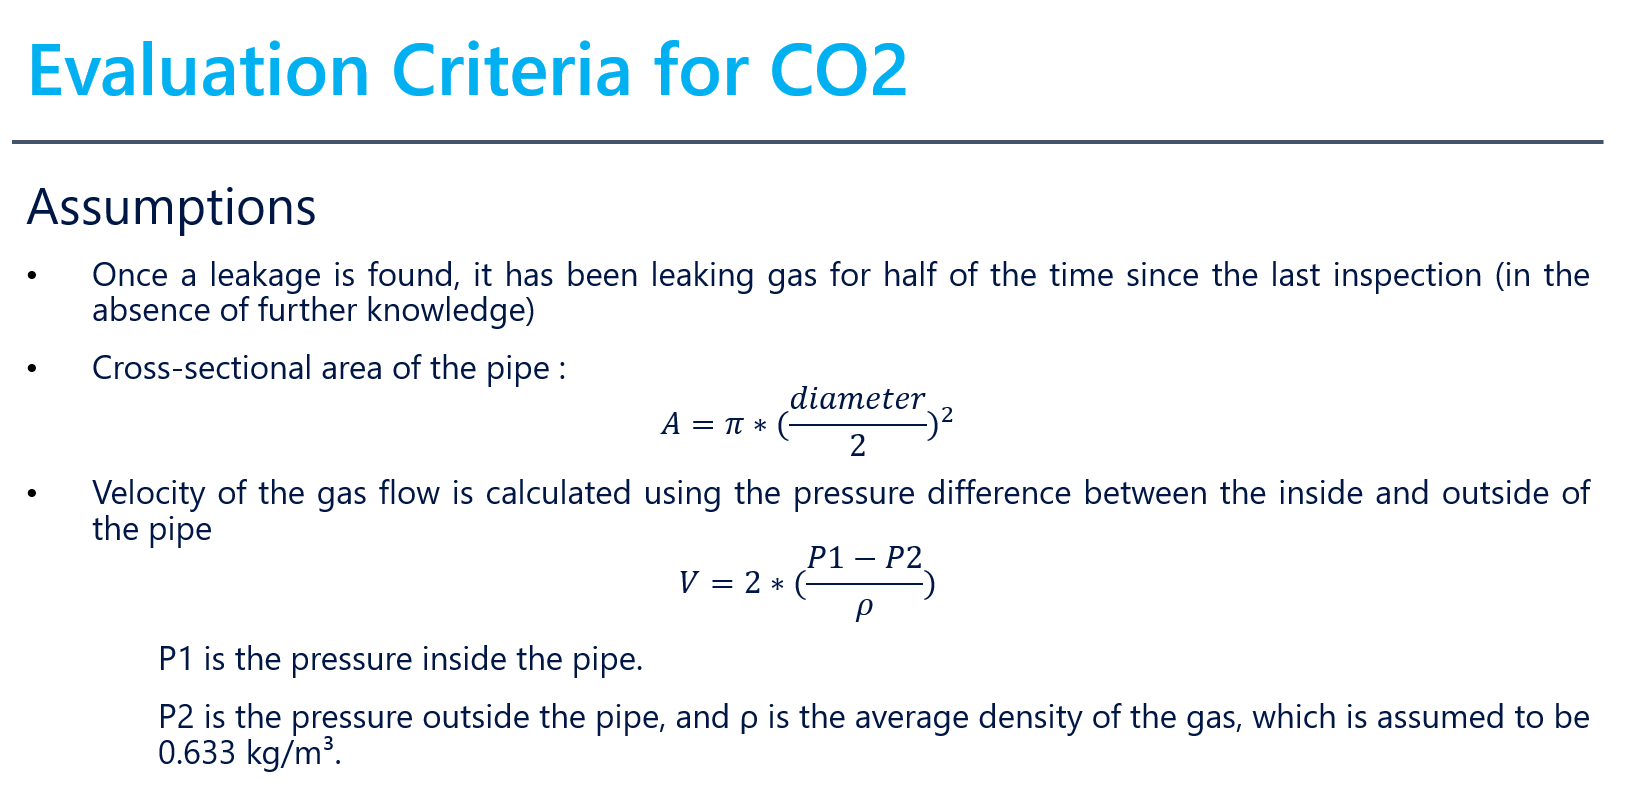

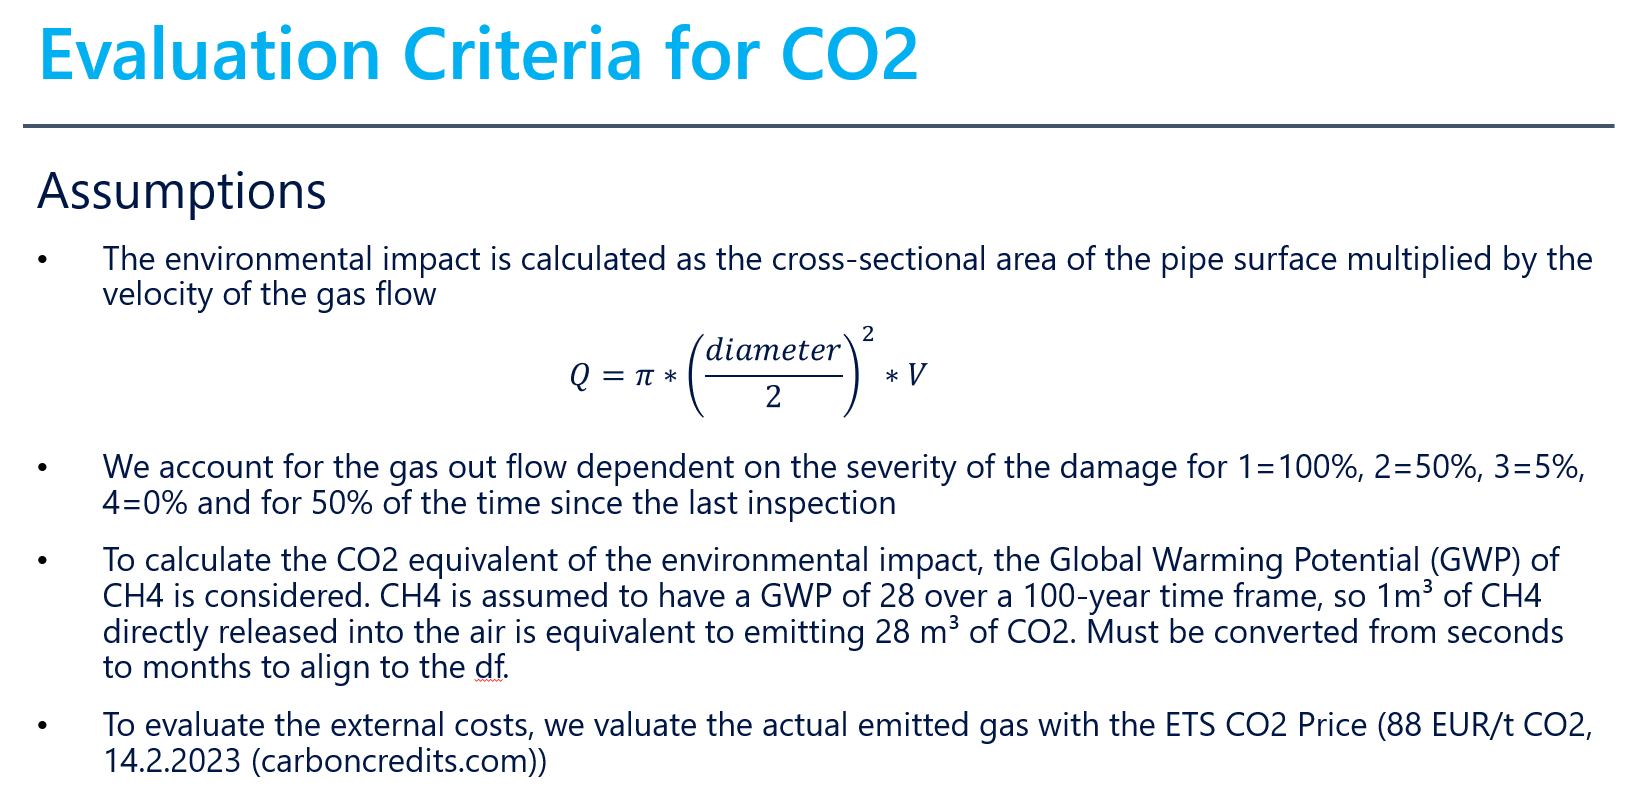

In [17]:
# Formula for Environmental Impact 
#                                                                       π * (D/2)²                            v=2 * (P1 - P2)                    / ρ    * time                *             CH4 potential * percentage severity * CO2 price
#      EUR                                                                  m2                  mm/m   *           m/s             /  bar/kPsc   / kg/m³ *s                    *                   t/m³       * []              * EUR/t
#
# result of co2_base costs

df_cost['b_Co2'] = np.where(df_cost['Severity'] == 1, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['NewMonthsLastRev']*0.5*2629800*28*1*88,
                            np.where(df_cost['Severity'] == 2, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['NewMonthsLastRev']*0.5*2629800*28*0.5*88,
                            np.where(df_cost['Severity'] == 3, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['NewMonthsLastRev']*0.5*2629800*28*0.05*88,
                            np.where(df_cost['Severity'] == 4, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['NewMonthsLastRev']*0.5*2629800*28*0*88, np.nan))))
df_cost.head()


,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,YearBuiltdate,Next_InspectionDate,NewMonthsLastRev,NewInspectionyear,b_Co2
0,446859944,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0,Valencia,Alginet,2012,...,44.286,0.15,0,0,False,2012-01-01,2021-08-17,32.0,2021,0.0
1,428124500,ZRV-00003028,2019.0,2019-01-10,24.0,4.0,0.0,Valencia,Alginet,2012,...,110.715,0.15,2,0,False,2012-01-01,2021-01-13,24.0,2021,0.0
2,438428871,ZRV-00003028,2019.0,2018-12-27,23.0,4.0,0.0,Valencia,Alginet,2012,...,13.575,0.15,0,0,False,2012-01-01,2021-07-07,30.0,2021,0.0
3,429034569,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0,Valencia,Alginet,2012,...,327.689,0.15,3,0,False,2012-01-01,2022-12-19,48.0,2022,0.0
4,411184477,ZRV-00003028,2019.0,2018-12-20,23.0,4.0,0.0,Valencia,Alginet,2007,...,932.762,0.15,0,0,False,2007-01-01,2021-08-01,31.0,2021,0.0


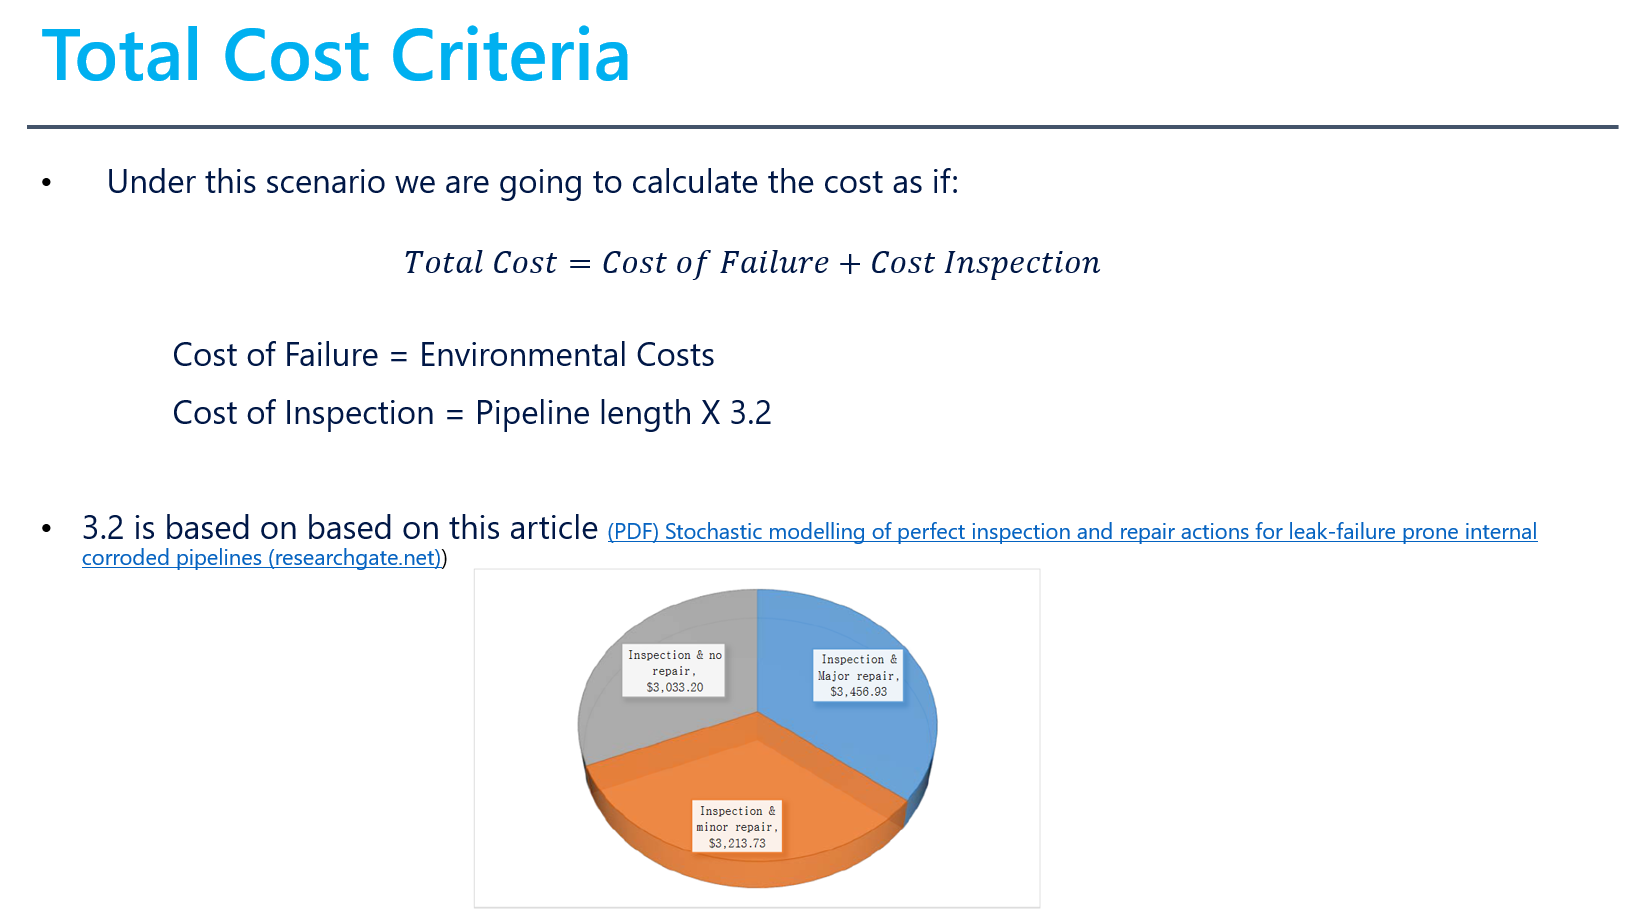

In [18]:
# sum costs for baseline scenario
results = pd.DataFrame()

#efficiency measure - time between failure and detection - expressed as sum of days of malfunctioning hardware

#df_cost['LastInspect'] = df_cost['Next_InspectionDate'] - pd.TimedeltaIndex(df_cost['NewMonthsLastRev'], unit='h')
df_cost['b_timedifference']=(df_cost['Next_InspectionDate']-df_cost['InspectionDate']).dt.total_seconds()/(24*60*60*30) 

results['b_timedifference'] = df_cost.groupby("NewInspectionyear").sum()["b_timedifference"]

# failure costs
results['b_failure_costs'] = df_cost.groupby("NewInspectionyear").sum()["b_Co2"]

# inspection costs // per length
df_cost['b_insp_costs'] = df_cost['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13
results['b_insp_costs'] = df_cost.groupby("NewInspectionyear").sum()["b_insp_costs"]

# total costs
results['b_total_costs'] = results['b_failure_costs'] + results['b_insp_costs']

results


,b_timedifference,b_failure_costs,b_insp_costs,b_total_costs
NewInspectionyear,,,,
2021,1.171300e+07,4.446517e+06,5.689848e+07,6.134500e+07
2022,1.676469e+07,8.636906e+06,5.518882e+07,6.382573e+07


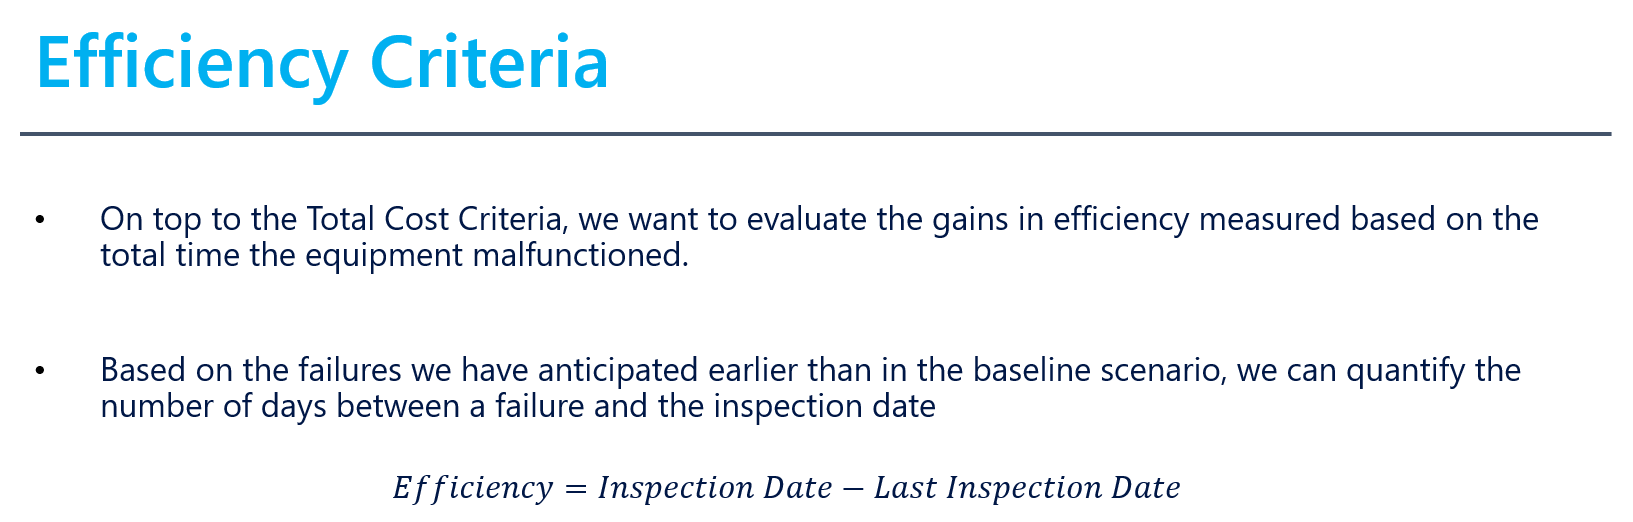

In [19]:
#efficiency measure is a proxy of the time between failure and detection, based on data available we will expressed as sum of days
#between the inspection date and the last inspection date

#df_cost['LastInspect'] = df_cost['Next_InspectionDate'] - pd.TimedeltaIndex(df_cost['NewMonthsLastRev'], unit='h')
df_cost['b_timedifference']=(df_cost['Next_InspectionDate']-df_cost['InspectionDate']).dt.total_seconds()/(24*60*60*30) 
results['b_timedifference'] = df_cost.groupby("NewInspectionyear").sum()["b_timedifference"]
results

,b_timedifference,b_failure_costs,b_insp_costs,b_total_costs
NewInspectionyear,,,,
2021,1.171300e+07,4.446517e+06,5.689848e+07,6.134500e+07
2022,1.676469e+07,8.636906e+06,5.518882e+07,6.382573e+07


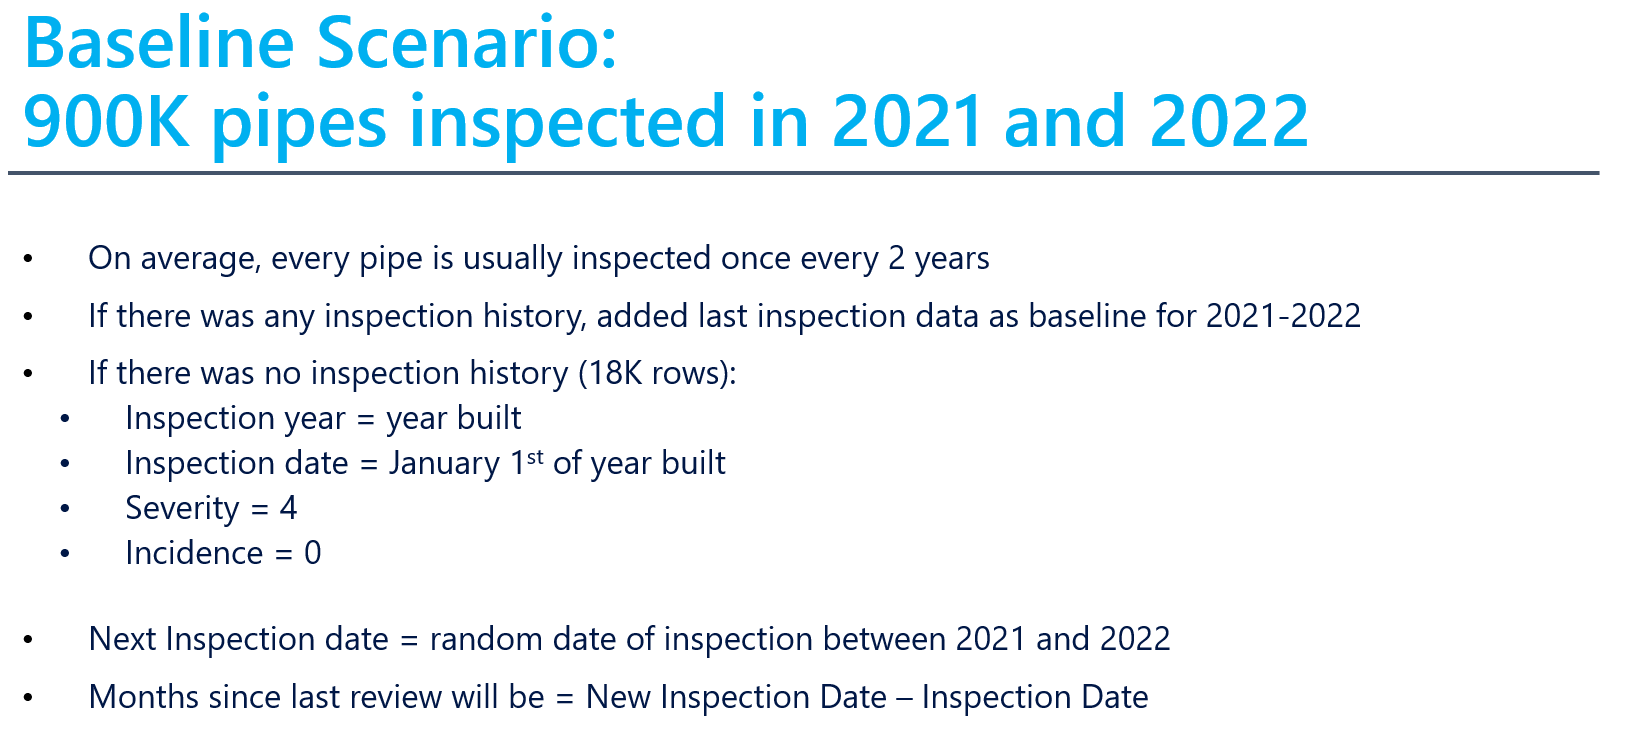

# Parameter Set for Optimized Scenarios 

In [20]:
# For now, randomly assigning class variable 1 or 0 and probability of failure. It needs to be replaced by the probabilty out of the ML model

os.chdir(r"C:\Users\dianaf\OneDrive\IE\Datathon") 

kaggle_submission_pca= pd.read_csv("kaggle_submission_pca.csv") #909733 rows - test data set with probabilities
df_cost = pd.merge(df_cost, kaggle_submission_pca, on="PipeId", how='right')
df_cost


,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence_x,Province,Town,YearBuilt,...,NumConnectionsUnder,BoolBridle,YearBuiltdate,Next_InspectionDate,NewMonthsLastRev,NewInspectionyear,b_Co2,b_timedifference,b_insp_costs,Incidence_y
0,446859944,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0,Valencia,Alginet,2012,...,0,False,2012-01-01,2021-08-17,32.0,2021,0.0,32.100000,141.7152,0.000286
1,428124500,ZRV-00003028,2019.0,2019-01-10,24.0,4.0,0.0,Valencia,Alginet,2012,...,0,False,2012-01-01,2021-01-13,24.0,2021,0.0,24.466667,354.2880,0.007942
2,438428871,ZRV-00003028,2019.0,2018-12-27,23.0,4.0,0.0,Valencia,Alginet,2012,...,0,False,2012-01-01,2021-07-07,30.0,2021,0.0,30.766667,43.4400,0.000255
3,429034569,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0,Valencia,Alginet,2012,...,0,False,2012-01-01,2022-12-19,48.0,2022,0.0,48.400000,1048.6048,0.007942
4,411184477,ZRV-00003028,2019.0,2018-12-20,23.0,4.0,0.0,Valencia,Alginet,2007,...,0,False,2007-01-01,2021-08-01,31.0,2021,0.0,31.833333,2984.8384,0.007942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,235426649,ZRV-00004383,2020.0,2020-01-16,24.0,4.0,0.0,Valencia,Paterna,2004,...,0,False,2004-01-01,2021-05-01,15.0,2021,0.0,15.700000,24.4992,0.000279
909729,235426673,ZRV-00004383,2020.0,2020-01-16,24.0,4.0,0.0,Valencia,Paterna,2004,...,0,False,2004-01-01,2021-06-07,17.0,2021,0.0,16.933333,14.0256,0.000586
909730,235426707,ZRV-00004383,2020.0,2020-01-16,24.0,4.0,0.0,Valencia,Paterna,2004,...,0,False,2004-01-01,2022-02-22,25.0,2022,0.0,25.600000,7.3344,0.000318
909731,190956601,ZRV-00004383,2020.0,2020-01-03,24.0,4.0,0.0,Valencia,Paterna,2004,...,0,False,2004-01-01,2022-04-08,27.0,2022,0.0,27.533333,280.9888,0.000286


In [21]:
# The idea of this optimization scenario is to run it week by week from start_date to end_date and selects those pipes with the highest probability of failure 

# 1st: we have to define parameters for the discrete optimization model for scenario centralized and decentralized

start_date_str = "2021-01-01"
end_date_str = "2022-12-31"

start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

# 2nd: set the number of inspected pipes per week for each iteration, it can be adjust/changed based on our EDA

num_selected = 20


#3rd: we evaluate every inspection based on CO2 costs which evolve due to leaking gas. df['fco2'] is the factor we multiply with the time of leakage


df_cost['fco2'] = np.where(df_cost['Severity'] == 1, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*1*88,
                            np.where(df_cost['Severity'] == 2, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0.5*88,
                            np.where(df_cost['Severity'] == 3, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0.05*88,
                            np.where(df_cost['Severity'] == 4, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0*88, np.nan))))



# reformat inspection date and lastInspect for datetime 
#df_cost['LastInspect'] = df_cost['Next_InspectionDate'] - pd.TimedeltaIndex(df_cost['NewMonthsLastRev']*4, unit='W')



In [22]:
df_cost.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence_x,Province,Town,YearBuilt,...,BoolBridle,YearBuiltdate,Next_InspectionDate,NewMonthsLastRev,NewInspectionyear,b_Co2,b_timedifference,b_insp_costs,Incidence_y,fco2
0,446859944,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0,Valencia,Alginet,2012,...,False,2012-01-01,2021-08-17,32.0,2021,0.0,32.100000,141.7152,0.000286,0.0
1,428124500,ZRV-00003028,2019.0,2019-01-10,24.0,4.0,0.0,Valencia,Alginet,2012,...,False,2012-01-01,2021-01-13,24.0,2021,0.0,24.466667,354.2880,0.007942,0.0
2,438428871,ZRV-00003028,2019.0,2018-12-27,23.0,4.0,0.0,Valencia,Alginet,2012,...,False,2012-01-01,2021-07-07,30.0,2021,0.0,30.766667,43.4400,0.000255,0.0
3,429034569,ZRV-00003028,2019.0,2018-12-28,23.0,4.0,0.0,Valencia,Alginet,2012,...,False,2012-01-01,2022-12-19,48.0,2022,0.0,48.400000,1048.6048,0.007942,0.0
4,411184477,ZRV-00003028,2019.0,2018-12-20,23.0,4.0,0.0,Valencia,Alginet,2007,...,False,2007-01-01,2021-08-01,31.0,2021,0.0,31.833333,2984.8384,0.007942,0.0


# Decentralized Scenario


In [23]:
#calculation of the costs for failure, with a focus on the environmental costs for CO2

#d...    d scenario
#CO2...  costs for failure with a focus on CO2
#base... costs for inspection per km pipe

In [24]:
# Create Dataframes for decentralized optimization

df_cost['d_Incidence_y']=df_cost['Incidence_y'] # d_random variable is the random variable which changes through out the simulation. 

#prepare time indicators for evaluating the failure function

#df_cost['d_InspectionDate_op'] = pd.to_datetime(df_cost['Next_InspectionDate'], format='%Y-%m-%d')
#df_cost['LastInspect'] = df_cost['Next_InspectionDate'] - pd.TimedeltaIndex(df_cost['NewMonthsLastRev'], unit='h')

df_cost['d_timedifference'] = pd.to_timedelta(1, unit='D') #this variable evaluates how long the mal supply took

#formatting all dates for datetime

#Create variable for the costs for mal supply and emitting CO2 into the atomosphere // external costs
df_cost['d_failure_costs'] = 0 

#create and format inspcetiondate

df_cost['d_InspectionDate_op'] = datetime(2021,1,1)

In [25]:
# Run through the optimization for the decentralized approach

pbar = tqdm(total=(end_date - start_date).days // 7)

# STEP 0: Create a loop structure to go through week by week

for date in pd.date_range(start_date, end_date, freq='W'):
     
# STEP 1: Take the highest n values of df['d_random_variable']
# select the top num_selected rows based on prediction input =(random variable)
    
    df_sorted = df_cost.sort_values('d_Incidence_y', ascending=False).iloc[:num_selected]
    
# STEP2: Add inspection date

#df_sorted['d_InspectionDate_op']
    
    df_cost.loc[df_cost.index.isin(df_sorted.index), 'd_InspectionDate_op'] = date
    
# STEP 3: Failure and Cost Valuation
    
    ####### CHEEEECCCCKKK!!!!
    df_sorted['d_timedifference'] =  (df_sorted['d_InspectionDate_op']-df_sorted['InspectionDate']).dt.total_seconds()/(24*60*60*30) 
    df_sorted['d_timedifference'] =  np.maximum(df_sorted['d_timedifference'], 0) #the max function insures, that if the last inspection in the data took place after the optimized inspection, that it is 0 and nonnegative
    df_cost.loc[df.index.isin(df_sorted.index), 'd_timedifference'] = df_sorted['d_timedifference']
 
    df_sorted['d_failure_costs'] =  df_sorted['d_timedifference'] *df_sorted['fco2']
    #df.loc[df_sorted.index, 'd_failure_costs'] = df_sorted['d_failure_costs'].copy() 
    df_cost.loc[df.index.isin(df_sorted.index), 'd_failure_costs'] = df_sorted['d_failure_costs']    
        
# STEP 4: Set back df['d_random_variable']

# 0.5  is an assumption that the risk for another failure is set off by 50% after inspection and repair
        
    df_sorted['d_Incidence_y'] =  df_sorted['d_Incidence_y']*0.5 
    #df.loc[df_sorted.index, 'd_random_variable'] = df_sorted['d_random_variable'].copy()
    df_cost.loc[df.index.isin(df_sorted.index), 'd_Incidence_y'] = df_sorted['d_Incidence_y']    

        
        # Update the progress bar

    pbar.update() # assuming we're iterating through weeks 



100%|██████████| 104/104 [04:11<00:00,  1.54s/it]

In [26]:
# sum costs for decentralized scenario

df_cost['d_inspection_year'] = df_cost['d_InspectionDate_op'].dt.year


#duration of malfunctioning

df_cost['d_timedifference'] = df_cost['d_timedifference'].apply(lambda x: int(x.days) if isinstance(x, pd.Timedelta) else x)
results['d_timedifference'] = df_cost.groupby("d_inspection_year").sum()["d_timedifference"]


# failure costs
results['d_failure_costs'] = df_cost.groupby("d_inspection_year").sum()["d_failure_costs"]

# inspection costs // per length
df_cost['d_insp_costs'] = df_cost['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13

results['d_insp_costs'] = df_cost.groupby("d_inspection_year").sum()["d_insp_costs"]

# total costs
results['d_total_costs'] = results['d_failure_costs'] + results['d_insp_costs']

results

,b_timedifference,b_failure_costs,b_insp_costs,b_total_costs,d_timedifference,d_failure_costs,d_insp_costs,d_total_costs
NewInspectionyear,,,,,,,,
2021,1.171300e+07,4.446517e+06,5.689848e+07,6.134500e+07,920948.633333,601042.079717,1.119473e+08,1.125483e+08
2022,1.676469e+07,8.636906e+06,5.518882e+07,6.382573e+07,17202.600000,74087.204151,1.400437e+05,2.141309e+05


# Centralized Scenario

In [27]:
# this is a restricted scenario, where the maintenance teams can only inspect pipes in one specific area of spain. 
# For that purpose we create a probability score indicator for the region to send out the maintenance team each week with highest score
# The teams are deployed in one region at a time and get´s redeployed to another region the next week 

In [28]:
# Create Dataframes for centralized optimization

df_cost['c_Incidence_y']=df_cost['Incidence_y'] # d_random varialbe is the random variable which changes through out the simulation. 

#prepare time indicators for evaluating the failure function


df_cost['c_timedifference'] = pd.to_timedelta(1, unit='D') #this variable evaluates how long the mal supply took

#Create variable for the costs for mal supply and emitting CO2 into the atomosphere // external costs
df_cost['c_failure_costs'] = 0 

In [29]:
# Run through the optimization for the centralized approach

#build a probility score for each region where the maintenance teams can operate within one timeperiode. 

#create a bar plot for the runntime
pbar = tqdm(total=(end_date - start_date).days // 7)

# STEP 0: Create a loop structure to go through week by week
for date in pd.date_range(start_date, end_date, freq='W'):
    
# STEP 1: Create the regional probability score table

    
    prob_score=df_cost.groupby("Province").sum()["c_Incidence_y"]
    df_cost['Prob_score'] = df_cost['Province'].map(prob_score)
    
    #df_sorted = df.sort_values('Prob_score', ascending=False).iloc[:num_selected]
    df_sorted = df_cost.sort_values(['Prob_score', 'c_Incidence_y'], ascending=[False, False]).iloc[:num_selected]

  # STEP2: Add inspection date

    df_sorted['c_InspectionDate_op']=date
    df_cost.loc[df_cost.index.isin(df_sorted.index), 'c_InspectionDate_op'] = date   
       
  # STEP 3: Failure and Cost Valuation
    
    df_sorted['c_timedifference'] =  (df_sorted['c_InspectionDate_op']-df_sorted['InspectionDate']).dt.total_seconds()/(24*60*60*30) 
    df_sorted['c_timedifference'] =  np.maximum(df_sorted['c_timedifference'], 0) #the max function insures, that if the last inspection in the data took place after the optimized inspection, that it is 0 and nonnegative
    df_cost.loc[df_cost.index.isin(df_sorted.index), 'c_timedifference'] = df_sorted['c_timedifference']
      
    df_sorted['c_failure_costs'] =  df_sorted['c_timedifference'] *df_sorted['fco2']
    df_cost.loc[df_sorted.index, 'c_failure_costs'] = df_sorted['c_failure_costs'].copy() 
           
   # STEP 4: Set back df['c_random_variable']

    df_sorted['c_Incidence_y'] =  df_sorted['c_Incidence_y']*0 # 0.5  is an assumption that the risk for another failure is set off by 50% after inspection and repair
    df_cost.loc[df_sorted.index, 'c_Incidence_y'] = df_sorted['c_Incidence_y'].copy()
            
        # Update the progress bar
    pbar.update()       

100%|██████████| 104/104 [04:14<00:00,  2.45s/it]


In [30]:
df_cost['c_inspection_year'] = df_cost['c_InspectionDate_op'].dt.year
df_cost['c_inspection_year'] 

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
909728   NaN
909729   NaN
909730   NaN
909731   NaN
909732   NaN
Name: c_inspection_year, Length: 909733, dtype: float64

In [31]:
# sum costs for decentralized scenario

#writing an inspection year for scenario centralized
df_cost['c_inspection_year'] = df_cost['c_InspectionDate_op'].dt.year


#duration of malfunctioning [months]

df_cost['c_timedifference'] = df_cost['c_timedifference'].apply(lambda x: int(x.days) if isinstance(x, pd.Timedelta) else x)
results['c_timedifference'] = df_cost.groupby("c_inspection_year").sum()["c_timedifference"]
# failure costs [EUR]
results['c_failure_costs'] = df_cost.groupby("c_inspection_year").sum()["c_failure_costs"]

# inspection costs // per length [EUR/km]
df_cost['c_insp_costs'] = df_cost['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13
results['c_insp_costs'] = df_cost.groupby("c_inspection_year").sum()["c_insp_costs"]

# total costs [EUR]
results['c_total_costs'] = results['c_failure_costs'] + results['c_insp_costs']

results



,b_timedifference,b_failure_costs,b_insp_costs,b_total_costs,d_timedifference,d_failure_costs,d_insp_costs,d_total_costs,c_timedifference,c_failure_costs,c_insp_costs,c_total_costs
NewInspectionyear,,,,,,,,,,,,
2021,1.171300e+07,4.446517e+06,5.689848e+07,6.134500e+07,920948.633333,601042.079717,1.119473e+08,1.125483e+08,24908.633333,1.866276e+06,126372.976000,1.992649e+06
2022,1.676469e+07,8.636906e+06,5.518882e+07,6.382573e+07,17202.600000,74087.204151,1.400437e+05,2.141309e+05,96753.466667,2.433718e+05,192804.598286,4.361764e+05


In [32]:
total_cost_comparision = pd.DataFrame()

total_cost_comparision['b_total_costs'] = results['b_total_costs']
total_cost_comparision['c_total_costs'] = results['c_total_costs']
total_cost_comparision['d_total_costs'] = results['d_total_costs']

total_cost_comparision

,b_total_costs,c_total_costs,d_total_costs
NewInspectionyear,,,
2021,6.134500e+07,1.992649e+06,1.125483e+08
2022,6.382573e+07,4.361764e+05,2.141309e+05


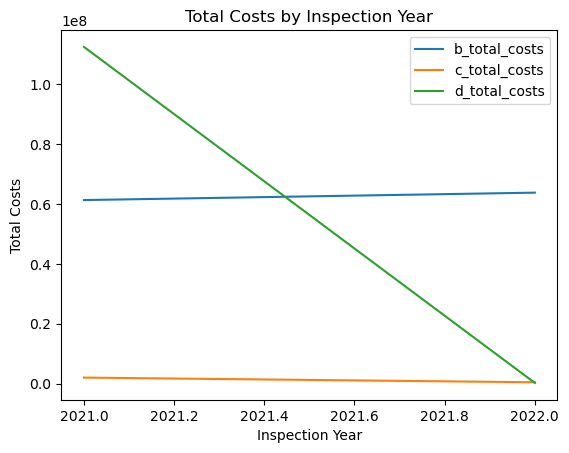

In [33]:
import matplotlib.pyplot as plt
# create the dataframe from the table
data = {'b_total_costs': total_cost_comparision['b_total_costs'],
        'c_total_costs': total_cost_comparision['c_total_costs'],
        'd_total_costs': total_cost_comparision['d_total_costs']}
df_p = pd.DataFrame(data, index=[2021,2022])

# create the figure and axis objects
fig, ax = plt.subplots()

# plot the lines
df_p.plot(ax=ax)

# set the title and axis labels
ax.set_title('Total Costs by Inspection Year')
ax.set_xlabel('Inspection Year')
ax.set_ylabel('Total Costs')

# show the plot
plt.show()


In [34]:
efficiency_comparision = pd.DataFrame()

efficiency_comparision['b_timedifference'] = results['b_timedifference']
efficiency_comparision['c_timedifference'] = results['c_timedifference']
efficiency_comparision['d_timedifference'] = results['d_timedifference']

efficiency_comparision

,b_timedifference,c_timedifference,d_timedifference
NewInspectionyear,,,
2021,1.171300e+07,24908.633333,920948.633333
2022,1.676469e+07,96753.466667,17202.600000


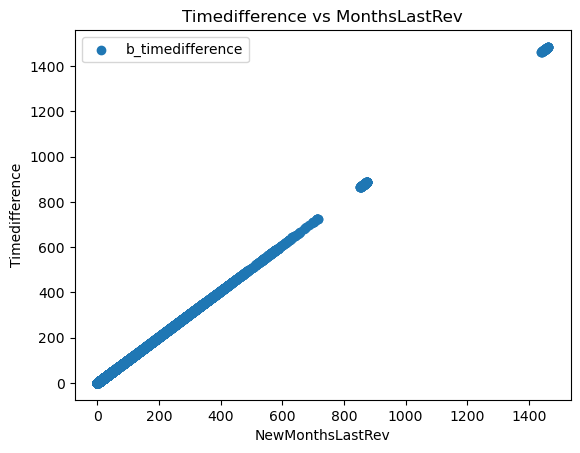

In [35]:
fig, ax = plt.subplots()

# plot b_timedifference
ax.scatter(df_cost['NewMonthsLastRev'], df_cost['b_timedifference'], label='b_timedifference', alpha=1)

# plot c_timedifference
#ax.scatter(df['MonthsLastRev'], df['c_timedifference'], label='c_timedifference', alpha=0.5)

# plot d_timedifference
#ax.scatter(df['Mont1qawöäsLastRev'], df['d_timedifference'], label='d_timedifference', alpha=0.5)

# set labels and title
ax.set_xlabel('NewMonthsLastRev')
ax.set_ylabel('Timedifference')
ax.set_title('Timedifference vs MonthsLastRev')

# set dynamic scale
ax.autoscale(enable=True, axis='both', tight=False)

# add legend
ax.legend()

plt.show()